In [1]:
from snowflake.snowpark import Session 
from dotenv import load_dotenv
import os
load_dotenv()

# use the env vars in comments above to set the vars below
OpenAI_API_KEY = os.getenv("OPENAI_API_KEY")
snowflake_account = os.getenv("SNOWFLAKE_ACCOUNT")
username = os.getenv("SNOWFLAKE_USER")
password = os.getenv("SNOWSQL_PWD")
warehouse = os.getenv("WAREHOUSE")
database = os.getenv("DATABASE")
schema = os.getenv("SCHEMA")
role = os.getenv("ROLE")


# print out all env vars using f-strings each on a separate line but x out password
print(f"OpenAI_API_KEY: {'x' * len(OpenAI_API_KEY)}")
print(f"snowflake_account: {snowflake_account}")
#print(f"username: {username}")
#print(f"password: {password}")
print(f"warehouse: {warehouse}")
print(f"database: {database}")
print(f"schema: {schema}")
print(f"role: {role}")




OpenAI_API_KEY: xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
snowflake_account: ie62028.ap-northeast-1.aws
warehouse: COMPUTE_WH
database: LEARNING_SQL
schema: PUBLIC
role: ACCOUNTADMIN


In [2]:
import snowflake.connector
import os

conn = snowflake.connector.connect(
    user=username,
    password=password,
    account=snowflake_account,
    warehouse=warehouse,
    database=database,
    schema=schema,
    role=role
    )



In [3]:
def execute_query(connection, query):
    '''
    return list of tuples from query
    usage:
    result = execute_query(conn, "DESCRIBE TABLE customer")
    for row in result:
        print(row)

    conn.close()
    '''
    cursor = connection.cursor()
    try:
        cursor.execute(query)
        # Fetch all rows
        rows = cursor.fetchall()
        # Alternatively, fetch one row at a time with cursor.fetchone()
        return rows
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        cursor.close()

In [4]:
import pandas as pd

def query_to_dataframe(connection, query):
    '''
    # Usage
    df = query_to_dataframe(conn, "SELECT * FROM customer")
    print(df)
    '''
    cursor = connection.cursor()
    try:
        cursor.execute(query)
        # Get the result set's column names
        columns = [col[0] for col in cursor.description]
        rows = cursor.fetchall()
        return pd.DataFrame(rows, columns=columns)
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        cursor.close()


### use Snowpark api

In [5]:
connection_parameters = {
    "user": username,
    "password": password,
    "account": snowflake_account,
    "warehouse": warehouse,
    "database": database,
    "schema": schema,
    "role": role
    
}

In [6]:
from snowflake.snowpark import Session

# Create a session object
session = Session.builder.configs(connection_parameters).create()

# Load a table as a DataFrame
df = session.table("customer")

# Perform DataFrame operations
df_filtered = df.filter(df['C_MKTSEGMENT'] == 'HOUSEHOLD')

# print head of dataframe but probably need to call collect(), count() or to_pandas() or show() to see
df_filtered.show()



# Collect the result back to the local machine as a Pandas DataFrame
pandas_df = df_filtered.to_pandas()

session.close()

#print(pandas_df.head())

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"C_CUSTKEY"  |"C_NAME"            |"C_ADDRESS"                            |"C_NATIONKEY"  |"C_PHONE"        |"C_ACCTBAL"  |"C_MKTSEGMENT"  |"C_COMMENT"                                         |
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|60001        |Customer#000060001  |9Ii4zQn9cX                             |14             |24-678-784-9652  |9957.56      |HOUSEHOLD       |l theodolites boost slyly at the platelets: per...  |
|60016        |Customer#000060016  |i5JCEL8FRYSLvOs1Lkqn30a,1jherLDP       |2              |12-259-973-3236  |4480.97      |HOUSEHOLD       |ongside of the final, pending dolphins? final t...  |
|60043        |Customer#0

In [7]:
# use my function to get a dataframe without an index column
# union drops duplicates and union all does not
df = query_to_dataframe(conn,
                        """select integer_val from (values (1), (2), (4), (7), (9))
                        as set_a (integer_val)
                        union
                        select integer_val
                        from (values (3), (5), (7), (9))
                        as set_b (integer_val)""")
df = df.reset_index(drop=True)
print(df.to_string(index=False))


 INTEGER_VAL
           1
           2
           4
           7
           9
           3
           5


In [8]:
from snowflake.snowpark import Session
import snowflake.snowpark.functions as F

# Assume you have already established a session with Snowflake
session = Session.builder.configs(connection_parameters).create()

# Create DataFrames for each set of values
df_set_a = session.create_dataframe([(1,), (2,), (4,), (7,), (9,)], schema=["integer_val"])
df_set_b = session.create_dataframe([(3,), (5,), (7,), (9,)], schema=["integer_val"])

# Perform a union operation
df_union = df_set_a.union(df_set_b)

# show the result
df_union.show()

# Perform a union all operation
df_union_all = df_set_a.union_all(df_set_b)

# Show the result
df_union_all.show()


-----------------
|"INTEGER_VAL"  |
-----------------
|1              |
|2              |
|4              |
|7              |
|9              |
|3              |
|5              |
-----------------

-----------------
|"INTEGER_VAL"  |
-----------------
|1              |
|2              |
|4              |
|7              |
|9              |
|3              |
|5              |
|7              |
|9              |
-----------------



In [9]:
query = """
    select distinct o_custkey
    from orders
    where o_totalprice > 350000
      and date_part (year, o_orderdate) = 1992
    union
    select distinct o_custkey
    from orders
    where o_totalprice < 350000
      and date_part (year, o_orderdate) = 1993;
"""
# call my function
df = query_to_dataframe(conn, query)

print(df.to_string(index=False))
#print(df)


 O_CUSTKEY
    143812
    112589
     32732
     51175
     45226
    101627
    106192
     46490
     50726
    110012
     58451
     37027
    147061
     67078
     81859
     40105
     50008
    143594
    132025
    109772
     82435
    116683
     24275
     32956
     30622
     87332
    130745
     70054
     52891
      8432
    145159
     79192
     61790
      4334
     63079
     32083
     20665
    100510
    107336
     33910
     59993
     24769
    120665
    146611
      9017
     49396
     53731
      5699
     86974
    149050
     24382
    112471
     39040
     57895
     74410
     58279
     97786
     18919
    107741
     50249
    129154
     10738
    124805
    108772
     62329
     58894
     78271
     18733
    114856
    137759
     23707
    123934
    107041
     12013
    122047
     48334
    110878
     26812
     84004
     91181
    138851
     16811
    132892
     55141
      1435
    126424
     46621
     97853
    135872
     75970

In [10]:
# Load a table as a DataFrame
df = session.table("orders")

# filter unique values for o_custkey, o_totalprice > 350000 and date_part of o_orderdate = 1992
df_orders_filtered = df.filter( 
    (df['o_totalprice'] > 350000) & 
    (F.year(df['o_orderdate']) == 1992)
)

# the other df for the union is the same as above but with 1993
df_orders_filtered_1993 = df.filter(
    (df['o_totalprice'] > 350000) & 
    (F.year(df['o_orderdate']) == 1993)
)

# Perform a union operation so no duplicates and only show distinct o_custkey
df_union = df_orders_filtered.union(df_orders_filtered_1993).select('o_custkey').distinct()


#df_union = df_orders_filtered.union(df_orders_filtered_1993)

print(df_union.count())

# print head of dataframe but probably need to call collect(), count() or to_pandas() or show() to see
df_union.show()

#df_union_distinct = df_union.distinct()
#print(df_union_distinct.count())



867
---------------
|"O_CUSTKEY"  |
---------------
|123934       |
|138851       |
|87332        |
|32956        |
|143594       |
|132025       |
|145159       |
|27520        |
|100510       |
|106192       |
---------------



In [11]:
# intersect
query = """
    select integer_val
    from (values (1), (2), (4), (7), (9))
    as set_a (integer_val)
    intersect
    select integer_val
    from (values (3), (5), (7), (9))
    as set_b (integer_val); 
"""
# call my function
df = query_to_dataframe(conn, query)
# print as string without index column
print(df.to_string(index=False))

 INTEGER_VAL
           7
           9


In [21]:
query = """select distinct o_custkey
    from orders
    where o_totalprice > 350000
      and date_part (year, o_orderdate) = 1992
    intersect
    select distinct o_custkey
    from orders
    where o_totalprice > 350000
      and date_part (year, o_orderdate) = 1993;"""

df = query_to_dataframe(conn, query)
print(df.to_string(index=False))


 O_CUSTKEY
    100510


In [22]:
# write code to find O_CUSTKEY=100510
# use the orders table
# use the o_custkey column

df = session.table("orders")
df_customer_100510 = df.filter(df['o_custkey'] == 100510)
df_customer_100510.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"O_ORDERKEY"  |"O_CUSTKEY"  |"O_ORDERSTATUS"  |"O_TOTALPRICE"  |"O_ORDERDATE"  |"O_ORDERPRIORITY"  |"O_CLERK"        |"O_SHIPPRIORITY"  |"O_COMMENT"                                         |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|4875268       |100510       |F                |412723.52       |1992-09-07     |4-NOT SPECIFIED    |Clerk#000000061  |0                 |beans. ironic somas                                 |
|4978438       |100510       |F                |353234.05       |1993-06-20     |5-LOW              |Clerk#000000240  |0                 |lly regular epitaphs. carefully ironic pinto be...  |
|2369122       |100510       |F         

In [25]:
from snowflake.snowpark import Session
import snowflake.snowpark.functions as F

# Establish a session with Snowflake
session = Session.builder.configs(connection_parameters).create()

# Load the 'orders' table
df = session.table("orders")

# Filter for orders in 1992 and 1993 with total price over 350,000
# make sure to select o_custkey column here for instersection since doing it last means multiple columns must be the same to be considered the intersection
df_orders_1992 = df.filter(
    (F.date_part("year", df['o_orderdate']) == 1992) &
    (df['o_totalprice'] > 350000)
).select("o_custkey")

df_orders_1993 = df.filter(
    (F.date_part("year", df['o_orderdate']) == 1993) &
    (df['o_totalprice'] > 350000)
).select("o_custkey")

# Show filtered results for debugging
df_orders_1992.show()
df_orders_1993.show()

# Perform intersect operation to find common customers
df_intersect = df_orders_1992.intersect(df_orders_1993)

# Show intersected result
df_intersect.show()


---------------
|"O_CUSTKEY"  |
---------------
|72538        |
|71590        |
|117593       |
|101603       |
|14020        |
|140188       |
|105058       |
|65950        |
|11890        |
|120407       |
---------------

---------------
|"O_CUSTKEY"  |
---------------
|96460        |
|40201        |
|42646        |
|80078        |
|28079        |
|131443       |
|142922       |
|86989        |
|26660        |
|36346        |
---------------

---------------
|"O_CUSTKEY"  |
---------------
|100510       |
---------------



In [27]:
# except operator example
query = """
    select integer_val
    from (values (1), (2), (4), (7), (9))
    as set_a (integer_val)
    except
    select integer_val
    from (values (3), (5), (7), (9))
    as set_b (integer_val);
"""
# call my function
df = query_to_dataframe(conn, query)
# print as string without index column
print(df.to_string(index=False))

# switch order of sets
query = """
    select integer_val
    from (values (3), (5), (7), (9))
    as set_a (integer_val)
    except
    select integer_val
    from (values (1), (2), (4), (7), (9))
    as set_b (integer_val);
"""
# call my function
df = query_to_dataframe(conn, query)
# print as string without index column
print(df.to_string(index=False))

 INTEGER_VAL
           1
           2
           4
 INTEGER_VAL
           3
           5


In [29]:
query = """ 
    select distinct o_custkey
    from orders
    where o_totalprice > 350000
      and date_part (year, o_orderdate) = 1992
    except
    select distinct o_custkey
    from orders
    where o_totalprice > 350000
      and date_part (year, o_orderdate) = 1993;
    """

df = query_to_dataframe(conn, query)
# print num rows
print(df.count())
print(df.to_string(index=False))


O_CUSTKEY    454
dtype: int64
 O_CUSTKEY
    146206
     33922
     88369
    141590
    109838
    130886
    121475
     96944
     66866
     82864
    147898
    132245
    127468
     58451
    149560
     48898
     34372
      8936
      3472
     20245
     50008
     66983
    143594
     15829
     65393
    147061
    111518
     91181
     46490
     37352
     42050
     86341
     36212
     73276
     43823
     26812
    126500
     85831
    147673
    149855
     27452
    106453
     61726
    138625
     78271
    128608
    121783
    122915
    103903
    132142
    143014
     39994
     36562
    146881
      2447
    105707
    124154
     74075
     78685
     48334
     34990
     20071
     29546
     82435
     81565
     32081
     37606
    112109
     65950
     41488
      2716
     14020
     58013
     51175
    118519
     83155
     22454
     93551
     21976
     97873
     84923
     26522
     68045
     27520
    112589
     21091
     43334
  

In [30]:
# use snowpark api to perform the above except operation
from snowflake.snowpark import Session
import snowflake.snowpark.functions as F

# Establish a session with Snowflake
session = Session.builder.configs(connection_parameters).create()

df = session.table("orders")

# Filter for orders in 1992 and 1993 with total price over 350,000
# make sure to select o_custkey column here for except since doing it last means multiple columns must be the same to be considered the intersection
df_orders_1992 = df.filter(
    (F.date_part("year", df['o_orderdate']) == 1992) &
    (df['o_totalprice'] > 350000)
).select("o_custkey")

df_orders_1993 = df.filter(
    (F.date_part("year", df['o_orderdate']) == 1993) &
    (df['o_totalprice'] > 350000)
).select("o_custkey")

# perform except operation to find customers in 1992 but not 1993
df_except = df_orders_1992.except_(df_orders_1993)
# print num rows
print(df_except.count())
# show the result
df_except.show()





454
---------------
|"O_CUSTKEY"  |
---------------
|20665        |
|92188        |
|32732        |
|52891        |
|26812        |
|122047       |
|143812       |
|106192       |
|137759       |
|50726        |
---------------



In [33]:
# using order by
query = """
    select distinct o_orderdate from orders
    intersect
    select distinct l_shipdate from lineitem
    order by o_orderdate;
"""

df = query_to_dataframe(conn, query)
# print num rows
print(df.count())
print(df.to_string(index=False))



O_ORDERDATE    2404
dtype: int64
O_ORDERDATE
 1992-01-03
 1992-01-04
 1992-01-05
 1992-01-06
 1992-01-07
 1992-01-08
 1992-01-09
 1992-01-10
 1992-01-11
 1992-01-12
 1992-01-13
 1992-01-14
 1992-01-15
 1992-01-16
 1992-01-17
 1992-01-18
 1992-01-19
 1992-01-20
 1992-01-21
 1992-01-22
 1992-01-23
 1992-01-24
 1992-01-25
 1992-01-26
 1992-01-27
 1992-01-28
 1992-01-29
 1992-01-30
 1992-01-31
 1992-02-01
 1992-02-02
 1992-02-03
 1992-02-04
 1992-02-05
 1992-02-06
 1992-02-07
 1992-02-08
 1992-02-09
 1992-02-10
 1992-02-11
 1992-02-12
 1992-02-13
 1992-02-14
 1992-02-15
 1992-02-16
 1992-02-17
 1992-02-18
 1992-02-19
 1992-02-20
 1992-02-21
 1992-02-22
 1992-02-23
 1992-02-24
 1992-02-25
 1992-02-26
 1992-02-27
 1992-02-28
 1992-02-29
 1992-03-01
 1992-03-02
 1992-03-03
 1992-03-04
 1992-03-05
 1992-03-06
 1992-03-07
 1992-03-08
 1992-03-09
 1992-03-10
 1992-03-11
 1992-03-12
 1992-03-13
 1992-03-14
 1992-03-15
 1992-03-16
 1992-03-17
 1992-03-18
 1992-03-19
 1992-03-20
 1992-03-21
 1992-0

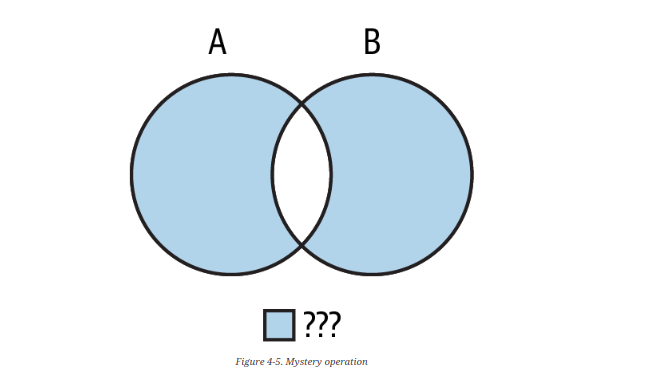

# use parantheses to make it work

In [35]:
query = """
    (select integer_val 
    from (values (1), (2), (4), (7), (9))
    as set_a (integer_val)
    except
    select integer_val
    from (values (3), (5), (7), (9))
    as set_b (integer_val)
    )
    union
    (select integer_val
    from (values (3), (5), (7), (9))
    as set_b (integer_val)
    except
    select integer_val
    from (values (1), (2), (4), (7), (9))
    as set_a (integer_val)
    ) 
    order by integer_val;
"""
# call my function
df = query_to_dataframe(conn, query)
# print as string without index column
print(df.to_string(index=False))

 INTEGER_VAL
           1
           2
           3
           4
           5
